## Семинар №4. Autoencoders


### План📝:

- #### Autoencoders
- #### Denoising Autoencoders
- #### Masked Autoencoders
- #### Variational Autoencoders

### Autoencoders

Идея автокодировщика заключается в обучении двух нейросетей:

- **`Encoder`**: Кодирует входные данные $\mathbf{x}$ в латентное представление $\mathbf{z}$ — вектор признаков меньшей размерности.

- **`Decoder`**: Восстанавливает исходные данные из этого латентного представления.

Латентный вектор $\mathbf{z}$ часто называют **бутылочным горлышком** (**bottleneck**), так как мы принуждаем сеть сжать входные данные, сохранив только самую важную информацию для их восстановления. Это свойство находит применение в задачах сжатия данных, шумоподавлении и поиске аномалий.

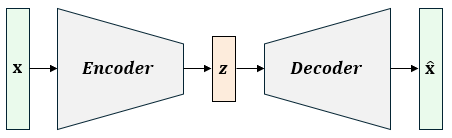

Классический автокодировщик является **полностью детерминированным**. Весь процесс — это прямая, последовательная цепочка преобразований.

In [1]:
import random
from typing import List, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

/home/jovyan/.mlspace/envs/nick_base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


На семинаре мы будем работать с датасетом  `MNIST`. Он состоит из черно-белых изображений рукописных цифр размером 28x28 пикселей.

Перед подачей в модель мы применим к изображениям два преобразования:

- `transforms.ToTensor()`: преобразует изображения из формата `PIL` в тензоры `PyTorch` и нормализует в диапазон от $0$ до $1$.

- `transforms.Normalize()`: нормализует тензоры в диапазон от $-1$ до $1$.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, transform=transform)
val_dataset = MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

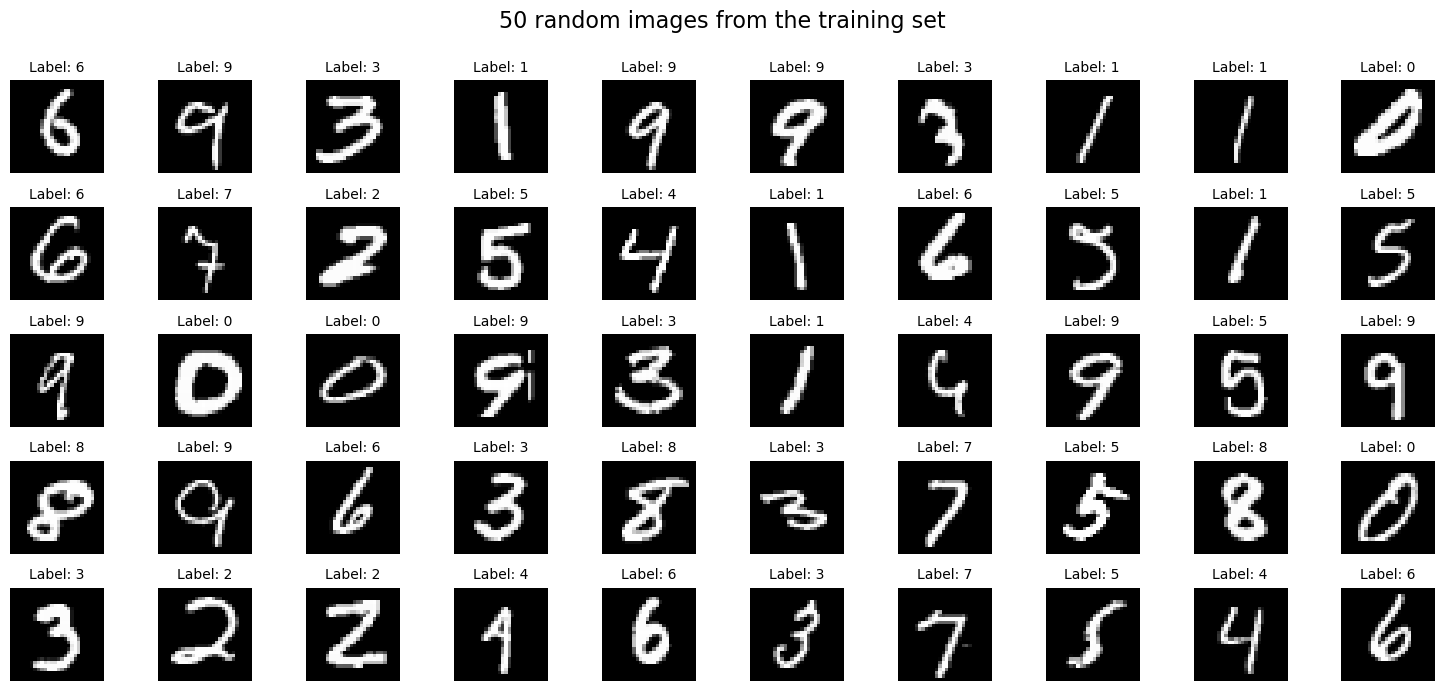

In [3]:
indices = random.sample(range(len(train_dataset)), 50)

images_labels = [train_dataset[i] for i in indices]
images, labels = zip(*images_labels)

images = [img.squeeze().numpy() * 0.5 + 0.5 for img in images]

fig, axes = plt.subplots(5, 10, figsize=(15, 7))
fig.suptitle('50 random images from the training set', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'Label: {labels[i]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

### Обучение автокодировщиков

Цель обучения — сделать реконструкцию $\hat{\mathbf{x}}$ максимально похожей на оригинал $\mathbf{x}$.

Сходство измеряется с помощью **ошибки восстановления** (**reconstruction loss**). В зависимости от типа данных, это может быть:

- **`Mean Squared Error`**: для вещественных данных

- **`Binary Cross-Entropy`**: для бинарных данных

In [4]:
class Autoencoder_MLP(nn.Module):
    def __init__(self,
                 input_dim: int, 
                 latent_dim: int,
                 hidden_dims: List = None) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim

        if hidden_dims is None:
            hidden_dims = [512, 256]

        encoder_layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            in_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_z = nn.Linear(hidden_dims[-1], latent_dim)

        decoder_layers = []
        in_dim = latent_dim
        decoder_hidden_dims = list(reversed(hidden_dims))
        for h_dim in decoder_hidden_dims:
            decoder_layers.append(nn.Linear(in_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            in_dim = h_dim
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.final_layer = nn.Sequential(
            nn.Linear(in_dim, input_dim),
            nn.Tanh() 
        )

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        input = input.view(-1, self.input_dim)
        result = self.encoder(input)
        z = self.fc_z(result)
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder(z)
        result = self.final_layer(result)
        return result

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        z = self.encode(input)
        recons = self.decode(z)
        return recons

In [5]:
def train(model, optimizer, train_loader, loss_fn, device):
    model.train()
    total_loss = 0.0

    for batch_x, _ in tqdm(train_loader, desc="Train", leave=False):
        x = batch_x.to(device)

        optimizer.zero_grad()
        recons = model(x)
        loss = loss_fn(recons, x.view(-1, model.input_dim))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(train_loader)


@torch.no_grad()
def validate(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0

    for batch_x, _ in tqdm(val_loader, desc="Val", leave=False):
        x = batch_x.to(device)

        recons = model(x)
        loss = loss_fn(recons, x.view(-1, model.input_dim))
        total_loss += loss.item()

    return total_loss / len(val_loader)


def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def train_and_validate(model, optimizer, train_loader, val_loader, loss_fn, num_epochs, device):
    model = model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        avg_train_loss = train(model, optimizer, train_loader, loss_fn, device)
        avg_val_loss = validate(model, val_loader, loss_fn, device)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        plot_losses(train_losses, val_losses)
        
        print(f"[Epoch {epoch}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
latent_dim = 64
num_epochs = 20
learning_rate = 1e-3

model = Autoencoder_MLP(input_dim=input_dim, latent_dim=latent_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
model

Autoencoder_MLP(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_z): Linear(in_features=256, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
  )
  (final_layer): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Tanh()
  )
)

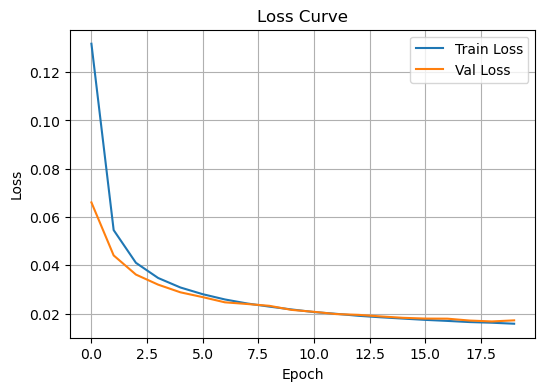

[Epoch 20/20] Train Loss: 0.015827 | Val Loss: 0.017220


In [9]:
train_and_validate(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    num_epochs=num_epochs,
    device=device
)

Попробуем использовать его для генерации новых изображений:

- Возьмем случайный вектор $\mathbf{z}$ из стандартного нормального распределения $\mathcal{N}(\mathbf{0}, \mathbf{I})$

- Подадим этот $\mathbf{z}$ на вход обученному декодеру

**Что мы получим на выходе?**

In [10]:
def generate_and_plot_from_ae(model, num_samples, latent_dim, device):
    model.eval()
    
    random_z = torch.randn(num_samples, latent_dim).to(device)
    generated_images = model.decode(random_z)
    
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = generated_images[i].detach().cpu().view(28, 28).numpy() * 0.5 + 0.5
        plt.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle("Generation")
    plt.show()


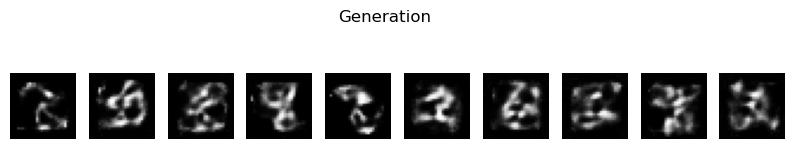

In [11]:
generate_and_plot_from_ae(model, num_samples=10, latent_dim=latent_dim, device=device)

### Latent Space

Визуализация латентного пространства — это хорший способ оценить, чему научилась наша модель. Значение функции потерь говорит нам, насколько хорошо модель восстанавливает изображения, а визуализация показывает, как она этого добивается.

Если модель хорошо обучилась, она должна размещать похожие друг на друга объекты в близких точках латентного пространства.

In [12]:
def visualize_latent_space(model, data_loader, device):

    model.eval()
    all_latents = []
    all_labels = []

    for images, labels in tqdm(data_loader):
        images = images.to(device)
        
        latents = model.encode(images)
        all_latents.append(latents.cpu())
        all_labels.append(labels.cpu())

    all_latents = torch.cat(all_latents).detach().numpy()
    all_labels = torch.cat(all_labels).detach().numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='tab10', alpha=0.7, s=10)
    
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.title("2D Latent Space")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    legend = plt.colorbar(scatter, ticks=range(10))
    legend.set_label("Class")
    
    plt.show()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
latent_dim = 2
num_epochs = 10
learning_rate = 1e-3

model_2d = Autoencoder_MLP(input_dim=input_dim, latent_dim=latent_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_2d.parameters(), lr=learning_rate)

In [14]:
for epoch in range(1, num_epochs + 1):
    loss = train(model_2d, optimizer, train_loader, loss_fn, device)
    print(f"[Epoch {epoch}/{num_epochs}] Train Loss: {loss:.6f}")

[Epoch 1/10] Train Loss: 0.205647


[Epoch 2/10] Train Loss: 0.170143


[Epoch 3/10] Train Loss: 0.162039


[Epoch 4/10] Train Loss: 0.157748


[Epoch 5/10] Train Loss: 0.154393


[Epoch 6/10] Train Loss: 0.152511


[Epoch 7/10] Train Loss: 0.150514


[Epoch 8/10] Train Loss: 0.149021


[Epoch 9/10] Train Loss: 0.147633


[Epoch 10/10] Train Loss: 0.146251


100%|██████████| 79/79 [00:00<00:00, 118.15it/s]


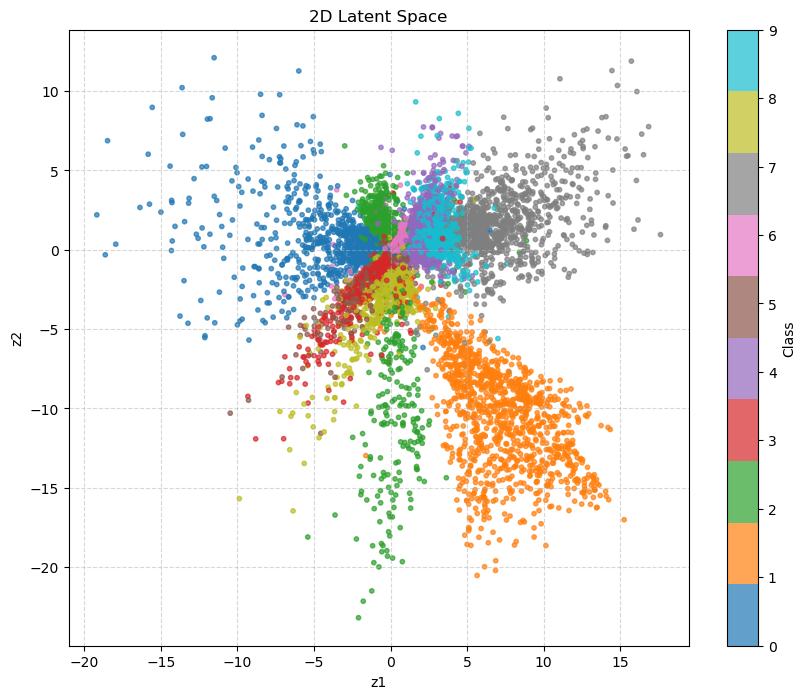

In [15]:
visualize_latent_space(model_2d, val_loader, device)

### Latent Dimension

Мы уже знаем, что латентный вектор $\mathbf{z}$ в автокодировщике служит "бутылочным горлышком", через которое должна пройти вся информация об исходном объекте $\mathbf{x}$. Размер этого горлышка, **`latent_dim`**, является одним из самых важных гиперпараметров модели.

Проверим, как меняется качество восстановления в зависимости от размера скрытого пространства.

In [16]:
def train_loop_for_experiment(model, optimizer, train_loader, val_loader, loss_fn, num_epochs, device):
    model = model.to(device)
    for epoch in range(1, num_epochs + 1):
        avg_train_loss = train(model, optimizer, train_loader, loss_fn, device)
        avg_val_loss = validate(model, val_loader, loss_fn, device)
        print(f"  [Epoch {epoch}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    return avg_val_loss

def plot_quality_vs_latent_dim(latent_dims, final_losses):
    plt.figure(figsize=(6, 3))
    plt.plot(latent_dims, final_losses, marker='o', linestyle='-')
    plt.xscale('log', base=2)
    plt.xlabel('Latent dim')
    plt.ylabel('Reconstruction loss, MSE')
    plt.title('Reconstruction Quality vs Latent Dimension')
    plt.xticks(latent_dims, labels=latent_dims)
    plt.grid(True, which="both", ls="--")
    plt.show()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
num_epochs_per_model = 5
learning_rate = 1e-3
loss_fn = nn.MSELoss()

latent_dims_to_test = [8, 16, 32, 64, 128]
final_validation_losses = []

--------------------------------------------------
Training model with latent_dim = 8


  [Epoch 1/5] Train Loss: 0.146127 | Val Loss: 0.093314


  [Epoch 2/5] Train Loss: 0.087918 | Val Loss: 0.080752


  [Epoch 3/5] Train Loss: 0.078522 | Val Loss: 0.074678


  [Epoch 4/5] Train Loss: 0.073574 | Val Loss: 0.071267


  [Epoch 5/5] Train Loss: 0.070239 | Val Loss: 0.068847
--------------------------------------------------
Training model with latent_dim = 16


  [Epoch 1/5] Train Loss: 0.132643 | Val Loss: 0.070578


  [Epoch 2/5] Train Loss: 0.063052 | Val Loss: 0.054847


  [Epoch 3/5] Train Loss: 0.052660 | Val Loss: 0.049642


  [Epoch 4/5] Train Loss: 0.047879 | Val Loss: 0.045398


  [Epoch 5/5] Train Loss: 0.044644 | Val Loss: 0.043016
--------------------------------------------------
Training model with latent_dim = 32


  [Epoch 1/5] Train Loss: 0.128159 | Val Loss: 0.064344


  [Epoch 2/5] Train Loss: 0.055321 | Val Loss: 0.046848


  [Epoch 3/5] Train Loss: 0.043056 | Val Loss: 0.038091


  [Epoch 4/5] Train Loss: 0.036785 | Val Loss: 0.033912


  [Epoch 5/5] Train Loss: 0.032977 | Val Loss: 0.031122
--------------------------------------------------
Training model with latent_dim = 64


  [Epoch 1/5] Train Loss: 0.131437 | Val Loss: 0.064180


  [Epoch 2/5] Train Loss: 0.054386 | Val Loss: 0.044530


  [Epoch 3/5] Train Loss: 0.040957 | Val Loss: 0.036616


  [Epoch 4/5] Train Loss: 0.034528 | Val Loss: 0.031978


  [Epoch 5/5] Train Loss: 0.030638 | Val Loss: 0.028593
--------------------------------------------------
Training model with latent_dim = 128


  [Epoch 1/5] Train Loss: 0.135777 | Val Loss: 0.066430


  [Epoch 2/5] Train Loss: 0.054557 | Val Loss: 0.044065


  [Epoch 3/5] Train Loss: 0.040511 | Val Loss: 0.035509


  [Epoch 4/5] Train Loss: 0.034033 | Val Loss: 0.031301


  [Epoch 5/5] Train Loss: 0.030053 | Val Loss: 0.027938


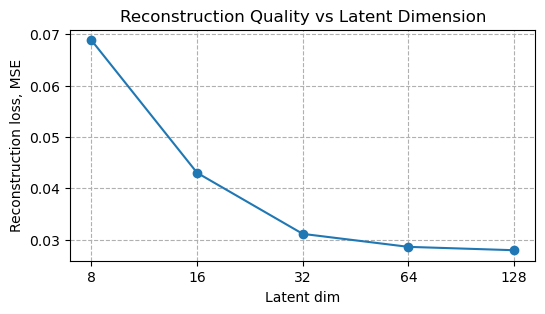

In [18]:
for ld in latent_dims_to_test:
    print("-" * 50)
    print(f"Training model with latent_dim = {ld}")
        
    model = Autoencoder_MLP(input_dim=input_dim, latent_dim=ld)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    final_loss = train_loop_for_experiment(
        model, optimizer, train_loader, val_loader, loss_fn, num_epochs_per_model, device
        )
        
    final_validation_losses.append(final_loss)

plot_quality_vs_latent_dim(latent_dims_to_test, final_validation_losses)

- При малых значениях `latent_dim` ошибка восстановления будет высокой, так как модель не способна запомнить все детали

- С увеличением `latent_dim` ошибка восстановления будет резко падать, так как у модели появляется все больше "пространства" для сохранения информации

- После определенного порога дальнейшее увеличение `latent_dim` даёт все меньший прирост качества

### Denoising Autoencoders

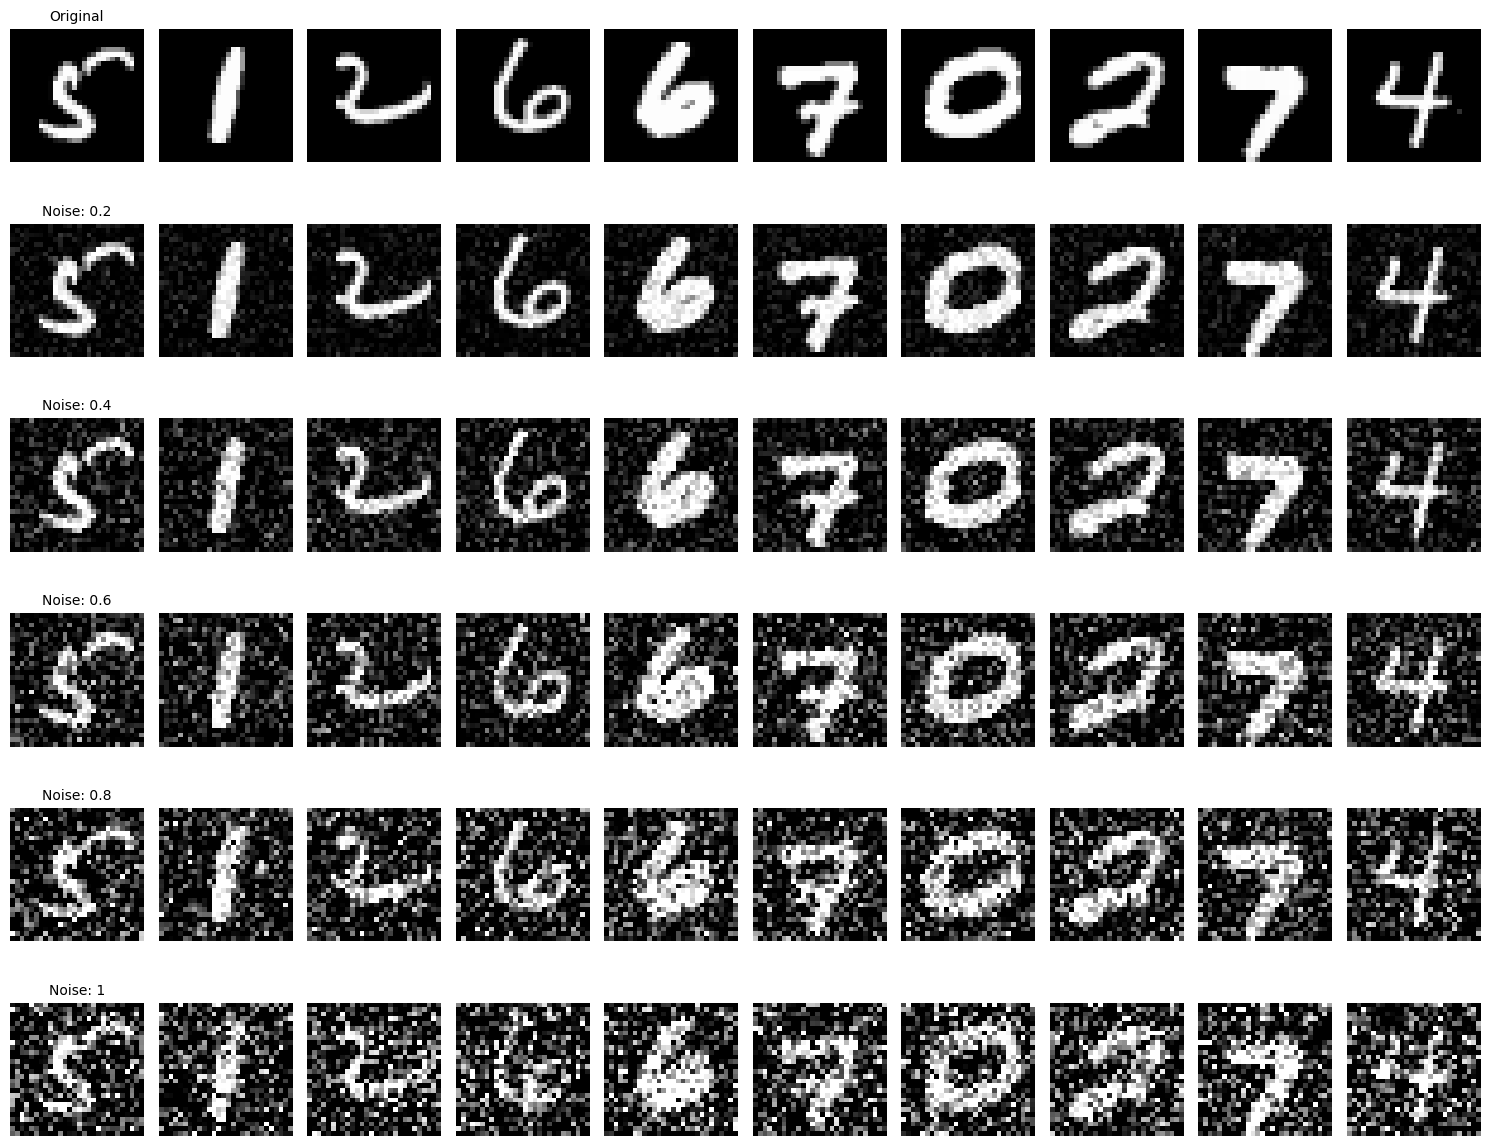

In [19]:
def show_noisy_images(data_loader, noise_factors, num_images=10):

    images, _ = next(iter(data_loader))
    images_to_show = images[:num_images]
    num_rows = len(noise_factors) + 1
    num_cols = len(images_to_show) 

    plt.figure(figsize=(15, 2 * num_rows))
    for i, image in enumerate(images_to_show):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        img_to_show = image.numpy() * 0.5 + 0.5
        plt.imshow(img_to_show.squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title("Original", fontsize=10)

    for j, noise_factor in enumerate(noise_factors):

        for i, image in enumerate(images_to_show):

            noisy_image = image + noise_factor * torch.randn_like(image)
            noisy_image = torch.clamp(noisy_image, -1, 1)

            ax = plt.subplot(num_rows, num_cols, (j + 1) * num_cols + i + 1)
            img_to_show = noisy_image.numpy() * 0.5 + 0.5
            plt.imshow(img_to_show.squeeze(), cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Noise: {noise_factor}", fontsize=10)
    plt.tight_layout()

    plt.show()

noises = [0.2, 0.4, 0.6, 0.8, 1]

show_noisy_images(train_loader, noises)

In [21]:
def train_step_denoising(model, optimizer, train_loader, loss_fn, device, noise_range=(0.1, 0.9)):
    model.train()
    total_loss = 0.0

    for batch_x, _ in tqdm(train_loader, desc="Denoising Train", leave=False):
        clean_x = batch_x.to(device)
        
        noise_factor = torch.rand(1).to(device) * (noise_range[1] - noise_range[0]) + noise_range[0]
        noisy_x = clean_x + noise_factor * torch.randn_like(clean_x)
        noisy_x = torch.clamp(noisy_x, -1, 1) 

        optimizer.zero_grad()

        recons = model(noisy_x)
        loss = loss_fn(recons, clean_x.view(-1, model.input_dim))
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

@torch.no_grad()
def validate_step_denoising(model, val_loader, loss_fn, device, noise_range=(0.1, 0.9)):
    model.eval()
    total_loss = 0.0

    for batch_x, _ in tqdm(val_loader, desc="Denoising Val", leave=False):
        clean_x = batch_x.to(device)

        noise_factor = torch.rand(1).to(device) * (noise_range[1] - noise_range[0]) + noise_range[0]
        noisy_x = clean_x + noise_factor * torch.randn_like(clean_x)
        noisy_x = torch.clamp(noisy_x, -1, 1)

        recons = model(noisy_x)
        loss = loss_fn(recons, clean_x.view(-1, model.input_dim))
        
        total_loss += loss.item()

    return total_loss / len(val_loader)

def visualize_denoising_progress(model, data_loader, device, num_images=10, noise_factor=0.5):
    model.eval()
    
    clean_x_batch, _ = next(iter(data_loader))
    clean_x = clean_x_batch[:num_images].to(device)
    noisy_x = clean_x + noise_factor * torch.randn_like(clean_x)
    noisy_x = torch.clamp(noisy_x, -1, 1)
    denoised_x = model(noisy_x)
    
    plt.figure(figsize=(num_images * 1.5, 5))
    
    for i in range(num_images):      
        ax = plt.subplot(3, num_images, i + 1)
        img_clean = clean_x[i].detach().cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_clean.squeeze(), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(3, num_images, num_images + i + 1)
        img_noisy = noisy_x[i].detach().cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_noisy.squeeze(), cmap='gray')
        ax.axis('off')
        
        ax = plt.subplot(3, num_images, 2 * num_images + i + 1)
        img_denoised = denoised_x[i].view(28, 28).detach().cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_denoised.squeeze(), cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
def train_loop_denoising(model, optimizer, train_loader, val_loader, loss_fn, num_epochs, device,
                         noise_range=(0.1, 0.9)):
    model = model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        avg_train_loss = train_step_denoising(model, optimizer, train_loader, loss_fn, device, noise_range=noise_range)
        avg_val_loss = validate_step_denoising(model, val_loader, loss_fn, device, noise_range=noise_range)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
    
        clear_output(wait=True)
        plot_losses(train_losses, val_losses)
        visualize_denoising_progress(model, val_loader, device, noise_factor=0.8)
        print(f"[Epoch {epoch}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
latent_dim = 64
num_epochs = 15
learning_rate = 1e-3

model = Autoencoder_MLP(input_dim=input_dim, latent_dim=latent_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

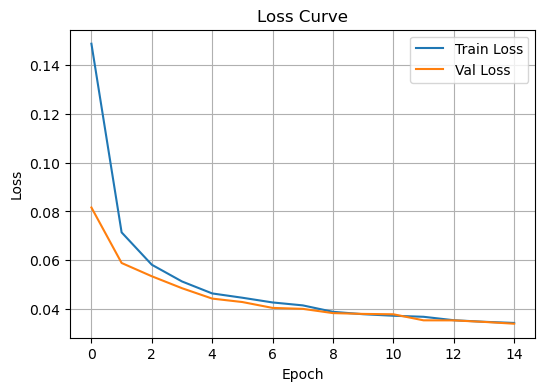

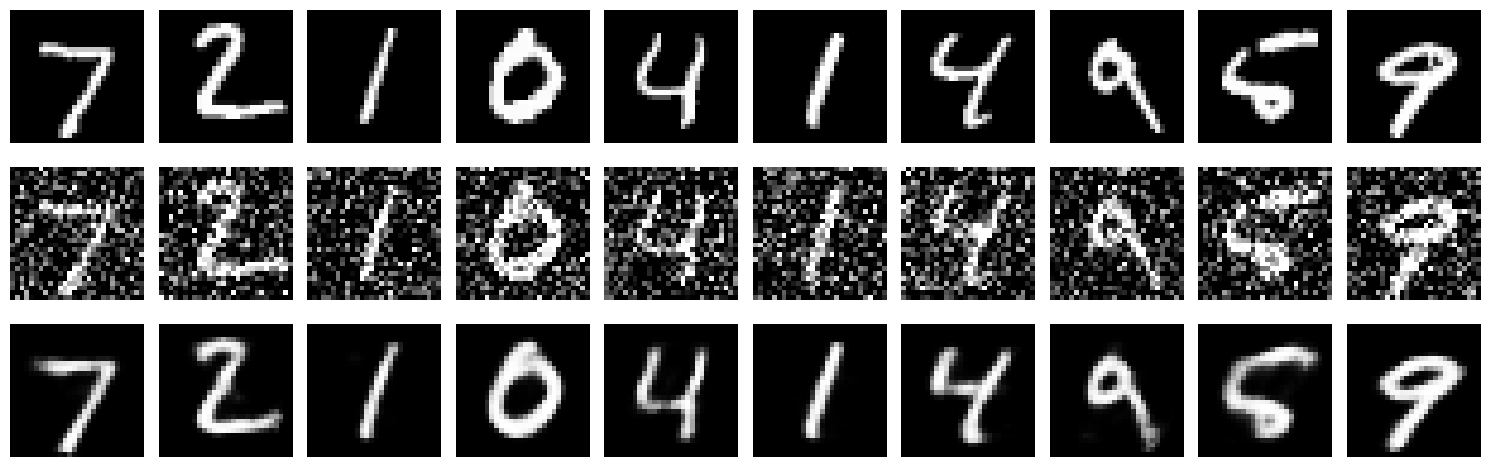

[Epoch 15/15] Train Loss: 0.034288 | Val Loss: 0.033970


In [25]:
train_loop_denoising(
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        num_epochs=num_epochs,
        device=device,
        noise_range=(0.1, 1)
    )

### Masked Autoencoders

In [26]:
def apply_random_masks(images, num_masks_range=(1, 5), 
                       size_range_h=(0.1, 0.25), 
                       size_range_w=(0.1, 0.25), 
                       value=-1.0):
                       
    masked_images = images.clone()
    batch_size, _, height, width = images.shape
    
    for i in range(batch_size):
        num_masks = random.randint(*num_masks_range)
        
        for _ in range(num_masks):
            mask_h = int(height * random.uniform(*size_range_h))
            mask_w = int(width * random.uniform(*size_range_w))
            
            if mask_h == 0 or mask_w == 0: continue
            
            top = random.randint(0, height - mask_h)
            left = random.randint(0, width - mask_w)
            
            masked_images[i, :, top:top + mask_h, left:left + mask_w] = value
            
    return masked_images

In [27]:
def train_step_inpainting(model, optimizer, train_loader, loss_fn, device, mask_params):
    model.train()
    total_loss = 0.0
    for batch_x, _ in tqdm(train_loader, desc="Inpainting Train", leave=False):
        clean_x = batch_x.to(device)
        
        masked_x = apply_random_masks(clean_x, **mask_params)
        
        optimizer.zero_grad()
        recons = model(masked_x)
        loss = loss_fn(recons, clean_x.view(-1, model.input_dim))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

@torch.no_grad()
def validate_step_inpainting(model, val_loader, loss_fn, device, mask_params):
    model.eval()
    total_loss = 0.0
    for batch_x, _ in tqdm(val_loader, desc="Inpainting Val", leave=False):
        clean_x = batch_x.to(device)
        
        masked_x = apply_random_masks(clean_x, **mask_params)

        recons = model(masked_x)
        loss = loss_fn(recons, clean_x.view(-1, model.input_dim))
        total_loss += loss.item()
    return total_loss / len(val_loader)

@torch.no_grad()
def visualize_inpainting_progress(model, data_loader, device, num_images=10, mask_params=None):
    model.eval()
    clean_x_batch, _ = next(iter(data_loader))
    clean_x = clean_x_batch[:num_images].to(device)
    masked_x = apply_random_masks(clean_x, **mask_params)
    denoised_x = model(masked_x)

    plt.figure(figsize=(num_images * 1.5, 5))
    
    for i in range(num_images):      
        ax = plt.subplot(3, num_images, i + 1)
        img_clean = clean_x[i].detach().cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_clean.squeeze(), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(3, num_images, num_images + i + 1)
        img_noisy = masked_x[i].detach().cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_noisy.squeeze(), cmap='gray')
        ax.axis('off')
        
        ax = plt.subplot(3, num_images, 2 * num_images + i + 1)
        img_denoised = denoised_x[i].view(28, 28).detach().cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_denoised.squeeze(), cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [28]:
def train_loop_inpainting(model, optimizer, train_loader, val_loader, loss_fn, num_epochs, device, 
                          train_mask_params, val_mask_params):
    model = model.to(device)
    train_losses, val_losses = [], []
    for epoch in range(1, num_epochs + 1):
        avg_train_loss = train_step_inpainting(model, optimizer, train_loader, loss_fn, device, train_mask_params)
        avg_val_loss = validate_step_inpainting(model, val_loader, loss_fn, device, val_mask_params)
        train_losses.append(avg_train_loss); val_losses.append(avg_val_loss)
        clear_output(wait=True)
        plot_losses(train_losses, val_losses)
        visualize_inpainting_progress(model, val_loader, device, mask_params=val_mask_params)
        print(f"[Epoch {epoch}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
latent_dim = 64
num_epochs = 15
learning_rate = 1e-3
mask_config = {'num_masks_range':(2, 8), 'size_range_h':(0.1, 0.4), 'size_range_w':(0.1, 0.4)}

model = Autoencoder_MLP(input_dim=input_dim, latent_dim=latent_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

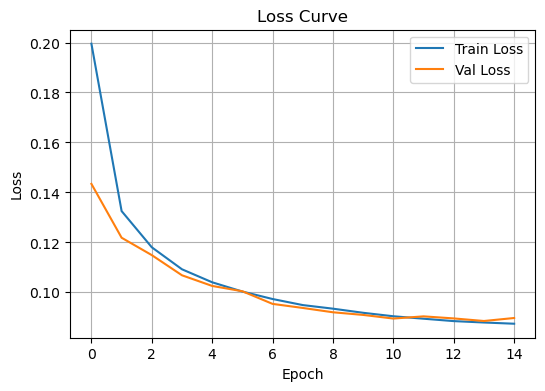

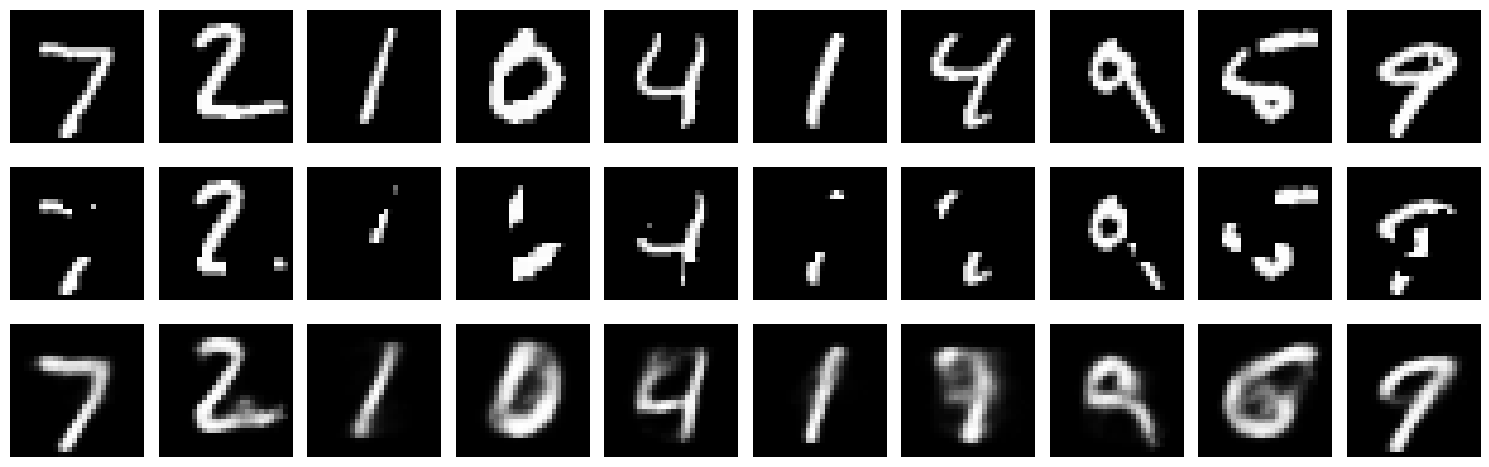

[Epoch 15/15] Train Loss: 0.087448 | Val Loss: 0.089737


In [30]:
train_loop_inpainting(
        model=model, 
        optimizer=optimizer, 
        train_loader=train_loader, 
        val_loader=val_loader,
        loss_fn=loss_fn, 
        num_epochs=num_epochs, 
        device=device,
        train_mask_params=mask_config, 
        val_mask_params=mask_config
    )

### Variational Autoencoder

Классические автоэнкодеры хорошо справляются с сжатием и реконструкцией данных, но у них есть ограничения при генерации новых данных

- **Неструктурированное Латентное Пространство**:

 В обычном `АЕ` нет правил, по которым должны быть расположены элементы в этом пространстве. Например, элементы для похожих картинок могут оказаться далеко друг от друга, а заметки для совершенно разных объектов могут быть рядом. 

Из-за этой беспорядочности нельзя просто взять случайный вектор $\mathbf{z}$ из этого пространства и ожидать, что декодер превратит ее во что-то осмысленное. Большая часть этого пространства будет пустой, и случайные точки из нее дадут на выходе декодера просто какой-то шум.

- **Отсутствие Разнообразия (Детерменированность)**:

Обычный `АЕ` для одной и той же входной картинки всегда создает одно и то же скрытое представление, что не позволяет создавать новые, разнообразные данные.

Итак, мы хотим сделать генеративную модель, которая не просто сжимает и восстанавливает данные, но и:

**1. Генерирует новые данные**

**2. Имеет структурированное и непрерывное латентное пространство**

Основная идея `VAE` заключается в том, что он кодирует входной объект $\mathbf{x}$ не в одну точку в скрытом пространстве, а в целое **вероятностное распределение** $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$. Обычно это нормальное распределение со средним $\boldsymbol{\mu}$ и дисперсией $\boldsymbol{\sigma}^2$. Это позволяет модели не просто сжимать данные, но и изучать гладкое, непрерывное скрытое пространство, что дает возможность генерировать новые объекты.

### Архитектура VAE

VAE состоит из двух основных частей, реализованных в виде нейросетей:

- **`Encoder`** $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$: его задача — аппроксимировать истинное, но невычислимое апостериорное распределение $p(\mathbf{z}|\mathbf{x})$. Он принимает на вход объект $\mathbf{x}$ и на выходе выдает параметры $\boldsymbol{\mu}$ и $\log \boldsymbol{\sigma}^2$ для распределения в скрытом пространстве.

- **`Decoder`** $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$: это генеративная часть модели, которая принимает на вход вектор $\mathbf{z}$, сэмплированный из скрытого пространства, и пытается восстановить из нее исходный объект $\mathbf{x}$.

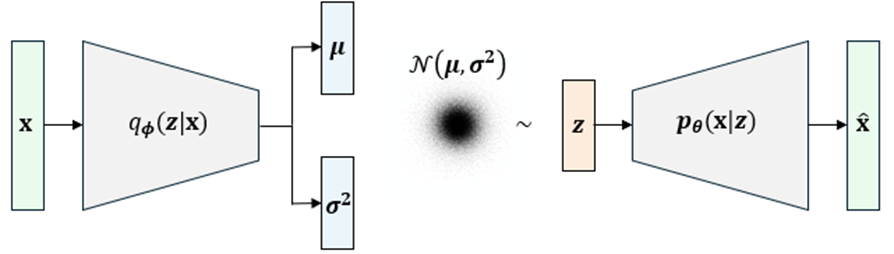

### Training

На каждом шаге обучения происходит следующий процесс:

- Объект $\mathbf{x}$ подается на вход **кодировщику**

- **Кодировщик** вычисляет векторы $\boldsymbol{\mu}$ и $\log \boldsymbol{\sigma}^2$

- Применяется **трюк репараметризации** (**Reparameterization Trick**) для сэмплирования $\mathbf{z}$:

  - **Сэмплируется шум** $\boldsymbol{\epsilon}$ из стандартного нормального распределения $\mathcal{N}(\mathbf{0}, \mathbf{I})$

  - Скрытый вектор вычисляется как $\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma}\cdot \boldsymbol{\epsilon}$

- Вектор $\mathbf{z}$ подается на вход декодеру

- Декодер выдает восстановленный объект $\hat{\mathbf{x}}$

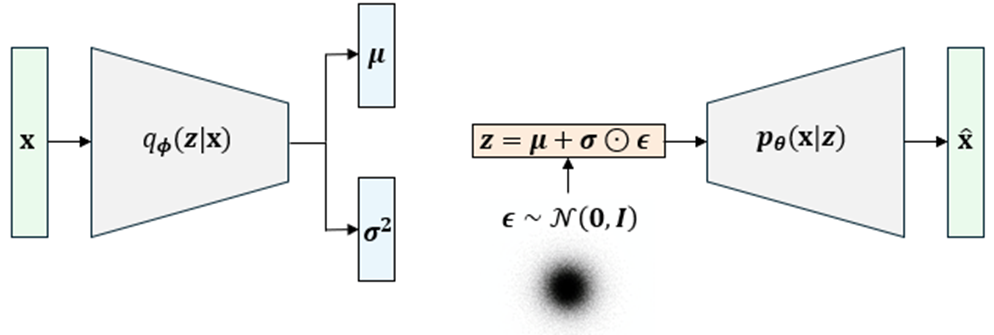

### Функция потерь

`VAE` обучается путем минимизации **отрицательной Нижней Вариационной Оценки** (**-ELBO**). Эта функция потерь состоит из двух членов:

$$\mathcal{L}_{\boldsymbol{\phi},\boldsymbol{\theta}}(\mathbf{x}) = \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})} [\log p(\mathbf{x}|\mathbf{z},\boldsymbol{\theta})] - KL(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p(\mathbf{z}))$$

### Sampling

- Нам больше не нужно кодировать существующие изображения, поэтому выбрасываем кодировщик $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$
- Сэмплируем $\mathbf{z}$ из априорного распределения $p(\mathbf{z}) = \mathcal{N}(\mathbf{0},\mathbf{I})$
- Подаем вектор $\mathbf{z}$ подается на вход нашему обученному декодеру $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$

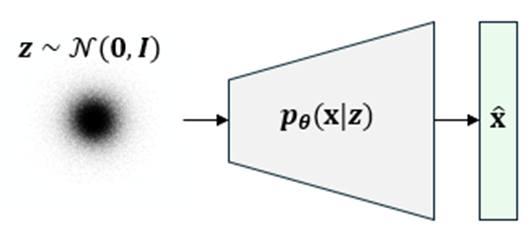

In [31]:
class VAE_MLP(nn.Module):
    def __init__(self,
                 input_dim: int,       
                 latent_dim: int,
                 hidden_dims: List = None) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        if hidden_dims is None:
            hidden_dims = [512, 256]

        encoder_layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            in_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        decoder_layers = []
        in_dim = latent_dim
        decoder_hidden_dims = list(reversed(hidden_dims))
        for h_dim in decoder_hidden_dims:
            decoder_layers.append(nn.Linear(in_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            in_dim = h_dim
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.final_layer = nn.Sequential(
            nn.Linear(in_dim, input_dim),
            nn.Tanh()
        )

    def encode(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        result = self.encoder(input.view(-1, self.input_dim))
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder(z)
        return self.final_layer(result)

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        recons = self.decode(z)
        return recons, mu, log_var

    def sample(self, num_samples: int, device: torch.device) -> torch.Tensor:
        z = torch.randn(num_samples, self.latent_dim).to(device)
        return self.decode(z)

In [ ]:
def loss_function(recons: torch.Tensor, 
                      input: torch.Tensor, 
                      mu: torch.Tensor, 
                      log_var: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    input_flat = input.view(-1, recons.shape[1])
    recons_loss = F.mse_loss(recons, input_flat, reduction='sum') / input.shape[0]
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / input.shape[0]
    loss = recons_loss + kld_loss
    
    return loss, recons_loss, kld_loss

In [33]:
def train_step_vae(model, optimizer, train_loader, device):
    model.train()
    total_loss, total_recon, total_kld = 0.0, 0.0, 0.0
    for batch_x, _ in tqdm(train_loader, desc="Train", leave=False):
        x = batch_x.to(device); optimizer.zero_grad()
        recons, mu, log_var = model(x)
        loss, recon_loss, kld_loss = loss_function(recons, x, mu, log_var)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kld += kld_loss.item()
    return {"loss": total_loss / len(train_loader), "recon_loss": total_recon / len(train_loader), "kld_loss": total_kld / len(train_loader)}

@torch.no_grad()
def validate_step_vae(model, val_loader, device):
    model.eval()
    total_loss, total_recon, total_kld = 0.0, 0.0, 0.0
    for batch_x, _ in val_loader:
        x = batch_x.to(device)
        recons, mu, log_var = model(x)
        loss, recon_loss, kld_loss = loss_function(recons, x, mu, log_var)
        total_loss += loss.item()
        total_recon += recon_loss.item() 
        total_kld += kld_loss.item()
    return {"loss": total_loss / len(val_loader), "recon_loss": total_recon / len(val_loader), "kld_loss": total_kld / len(val_loader)}

@torch.no_grad()
def visualize_generation(model, device, epoch, num_images=10):
    model.eval()
    samples = model.sample(num_images, device).cpu()
    plt.figure(figsize=(num_images * 1.5, 3))
    plt.suptitle(f'Generated Images after Epoch {epoch}', fontsize=16)
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = samples[i].reshape(28, 28).numpy() * 0.5 + 0.5
        plt.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

def plot_losses(train_stats, val_stats):

    clear_output(wait=True)
    epochs = range(1, len(train_stats['loss']) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    ax = axes[0]
    ax.plot(epochs, train_stats['loss'], label='Train Total Loss')
    ax.plot(epochs, val_stats['loss'], label='Validation Total Loss')
    ax.set_title('Total Loss, -ELBO')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()
    
    ax = axes[1]
    ax.plot(epochs, train_stats['recon_loss'], label='Train Recon Loss')
    ax.plot(epochs, val_stats['recon_loss'], label='Validation Recon Loss')
    ax.set_title('Reconstruction Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.grid(True)
    ax.legend()
    
    ax = axes[2]
    ax.plot(epochs, train_stats['kld_loss'], label='Train KLD Loss')
    ax.plot(epochs, val_stats['kld_loss'], label='Validation KLD Loss')
    ax.set_title('KL Divergence')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KLD')
    ax.grid(True)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [34]:
def train_loop_vae(model, optimizer, train_loader, val_loader, num_epochs, device):
    model = model.to(device)
    
    train_stats = {'loss': [], 'recon_loss': [], 'kld_loss': []}
    val_stats = {'loss': [], 'recon_loss': [], 'kld_loss': []}

    for epoch in range(1, num_epochs + 1):
        train_loss_dict = train_step_vae(model, optimizer, train_loader, device)
        val_loss_dict = validate_step_vae(model, val_loader, device)
        
        for key in train_stats:
            train_stats[key].append(train_loss_dict[key])
            val_stats[key].append(val_loss_dict[key])
        
        clear_output(wait=True)
        plot_losses(train_stats, val_stats)
        visualize_generation(model, device, epoch)
        
        print(f"[Epoch {epoch}/{num_epochs}]")
        print(f"  Train: Loss={train_loss_dict['loss']:.4f}, Recon={train_loss_dict['recon_loss']:.4f}, KLD={train_loss_dict['kld_loss']:.4f}")
        print(f"  Val:   Loss={val_loss_dict['loss']:.4f}, Recon={val_loss_dict['recon_loss']:.4f}, KLD={val_loss_dict['kld_loss']:.4f}")

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
latent_dim = 64
num_epochs = 30
learning_rate = 1e-3
hidden_dims = [512, 256, 128]

model = VAE_MLP(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=hidden_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

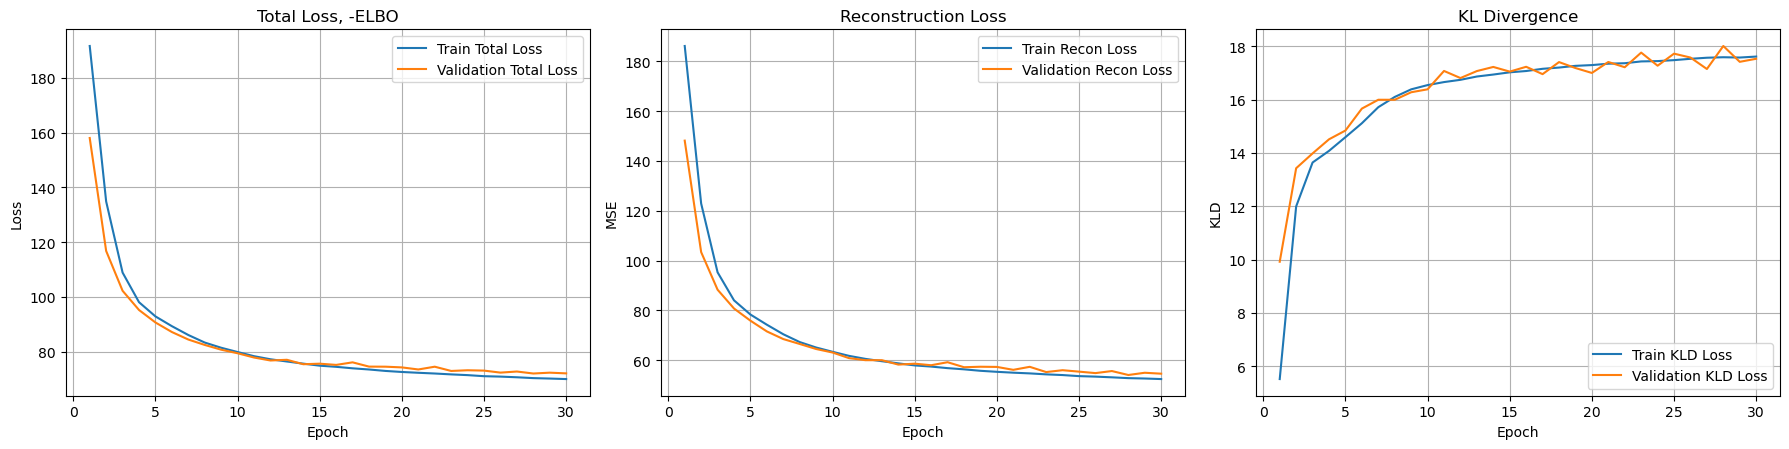

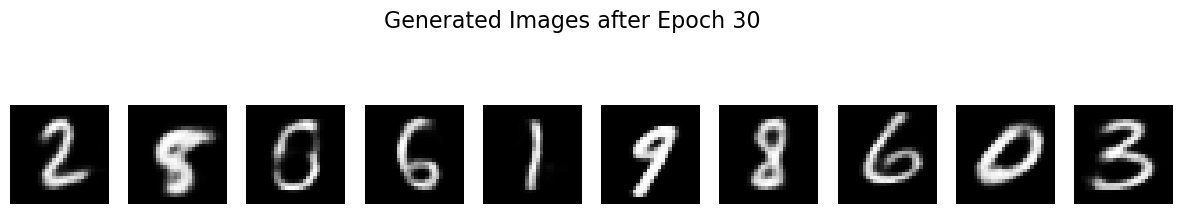

[Epoch 30/30]
  Train: Loss=70.0159, Recon=52.3991, KLD=17.6169
  Val:   Loss=72.0973, Recon=54.5632, KLD=17.5341


In [36]:
train_loop_vae(
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        device=device
    )

In [37]:
def generate_and_plot_grid(model, device, num_images=50, num_cols=10):
    model.eval()
    
    samples = model.sample(num_images, device).cpu()
    num_rows = (num_images + num_cols - 1) // num_cols 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 1.7))
        
    for i in range(num_images):
        ax = axes.flatten()[i]
        
        img = samples[i].reshape(28, 28).detach().numpy() * 0.5 + 0.5
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    for i in range(num_images, num_rows * num_cols):
        axes.flatten()[i].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

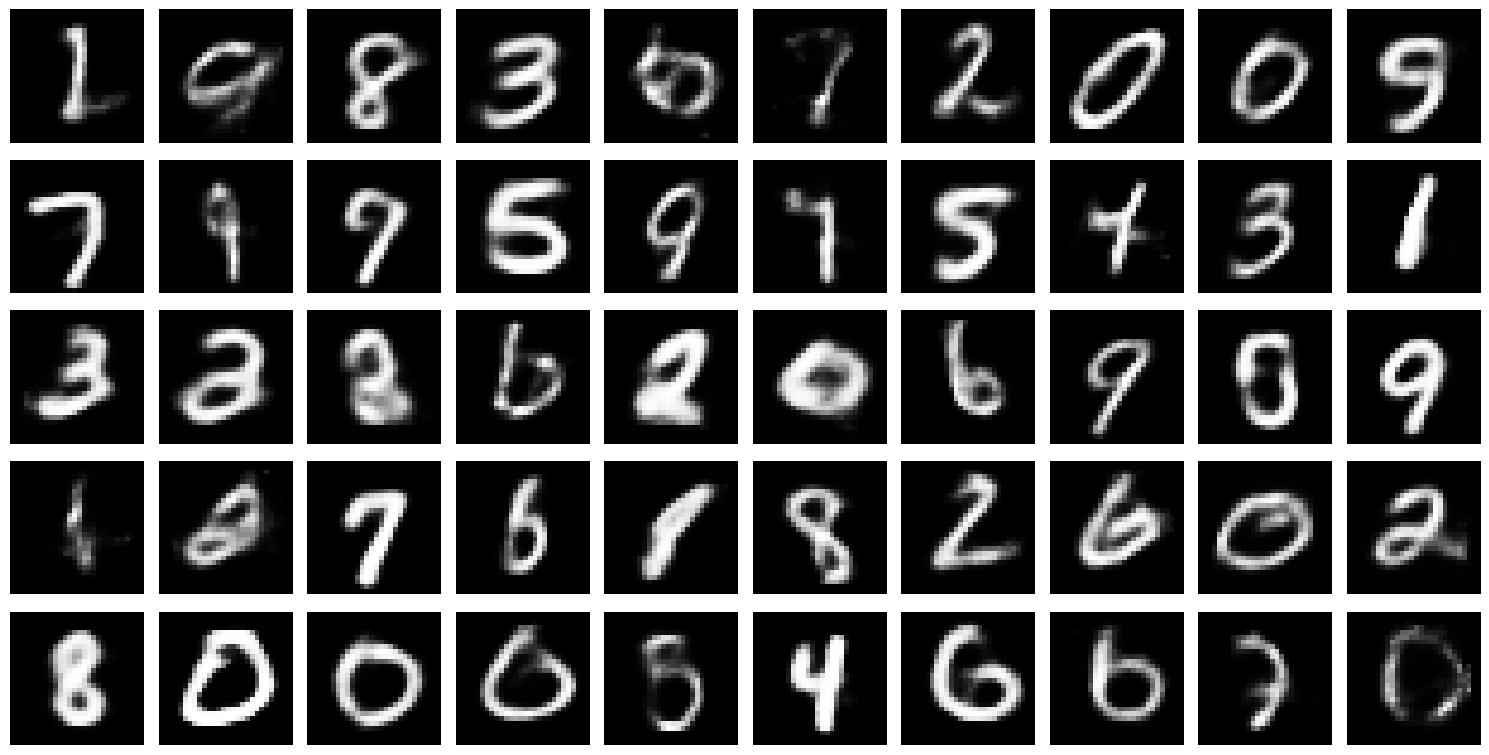

In [38]:
generate_and_plot_grid(model, device, num_images=50, num_cols=10)

### Latent Space VAE

In [39]:
def visualize_latent_space_vae(model, data_loader, device):
    model.eval()
    all_mus = []
    all_labels = []

    for images, labels in tqdm(data_loader):
        images = images.to(device)

        mu, _ = model.encode(images)
        all_mus.append(mu.cpu())
        all_labels.append(labels.cpu())

    all_mus = torch.cat(all_mus).detach().numpy()
    all_labels = torch.cat(all_labels).detach().numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_mus[:, 0], all_mus[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
    
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.title("2D Latent Space VAE")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal')
    
    legend = plt.colorbar(scatter, ticks=range(10))
    legend.set_label("Class")
    
    plt.show()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
latent_dim = 2
num_epochs = 10
learning_rate = 1e-3
model_2d_vae = VAE_MLP(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model_2d_vae.parameters(), lr=learning_rate)

In [41]:
for epoch in range(1, num_epochs + 1):
    model_2d_vae.train()
    total_loss = 0.0
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        recons, mu, log_var = model_2d_vae(x_batch)
        loss, _, _ = loss_function(recons, x_batch, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch}/{num_epochs}] Train Loss: {avg_loss:.4f}")

[Epoch 1/10] Train Loss: 173.0729
[Epoch 2/10] Train Loss: 145.1193
[Epoch 3/10] Train Loss: 138.5267
[Epoch 4/10] Train Loss: 134.4208
[Epoch 5/10] Train Loss: 131.2683
[Epoch 6/10] Train Loss: 128.9661
[Epoch 7/10] Train Loss: 127.6917
[Epoch 8/10] Train Loss: 126.2759
[Epoch 9/10] Train Loss: 125.3311
[Epoch 10/10] Train Loss: 124.3887


100%|██████████| 79/79 [00:00<00:00, 120.28it/s]


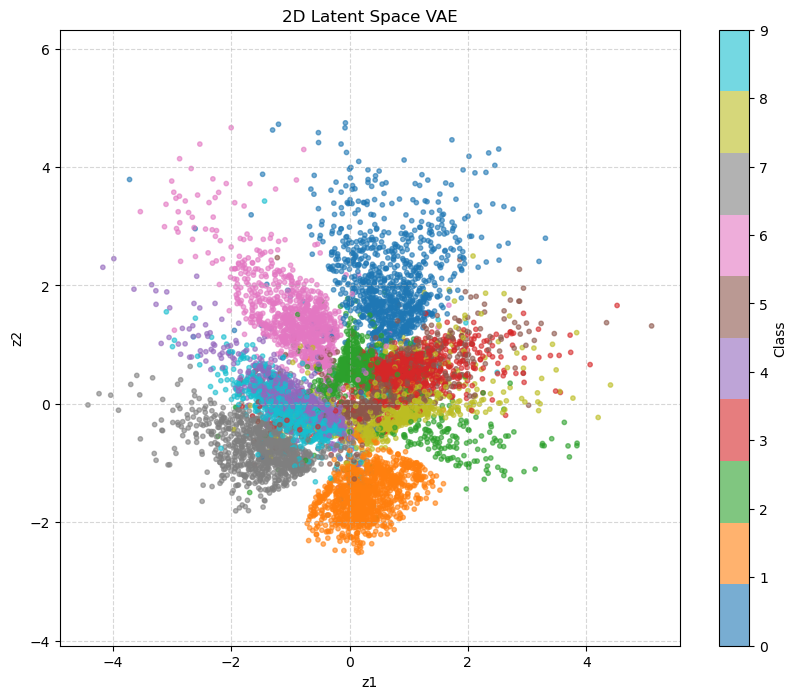

In [42]:
visualize_latent_space_vae(model_2d_vae, val_loader, device)